In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
from os.path import join
from collections import defaultdict
import numpy as np
import joblib
from tqdm import tqdm
import sys
from copy import deepcopy

import neuro.config as config
# sys.path.append(join(REPO_DIR, 'experiments'))
from neuro import viz, analyze_helper
from neuro.features.questions.gpt4 import QS_35_STABLE
from neurosynth import term_dict, term_dict_rev, get_neurosynth_flatmaps
neurosynth_compare = __import__('04_neurosynth_compare')
import viz
import neurosynth
from cortex import mni
import os
from statsmodels.stats.multitest import multipletests
config.setup_freesurfer()

Note, this notebook requires first running `03_export_qa_flatmaps.ipynb` into `df_qa_dict.pkl` files for each subject.

### compute correlations with qa flatmaps and plot avgs

In [2]:
# setting = 'shapley_neurosynth'
# setting = 'full_neurosynth'
# setting = 'individual_gpt4''
for settings in [
    # ['full_neurosynth_pc'],
    # ['full_neurosynth_wordrate_pc'],
    # ['full_35_pc'],
    # ['full_35_wordrate_pc'],
    # ['full_neurosynth'],
    # ['full_neurosynth_wordrate'],
    # ['full_35'],
    # ['full_35_wordrate'],
    # ['individual_gpt4'],
    ['individual_gpt4_ndel=1_pc_new'],
    # ['individual_gpt4_pc_new'],

]:
    print('settings', settings)
    # settings = ['']  # shapley_neurosynth, individual_gpt4
    subjects = ['UTS01', 'UTS02', 'UTS03']
    # subjects = [f'UTS0{i}' for i in range(1, 9)]

    # comparison hyperparams
    apply_mask = True
    frac_voxels_to_keep = 0.1  # 0.10
    frac_voxels_to_keep_list = [frac_voxels_to_keep]
    # hyperparams
    out_dir = join('neurosynth_compare', '___'.join(settings))

    # load flatmaps
    flatmaps_qa_dicts_by_subject = neurosynth.load_flatmaps_qa_dicts_by_subject(
        subjects, settings)

    corrs_df = neurosynth_compare.compute_corrs_df(
        frac_voxels_to_keep, subjects, flatmaps_qa_dicts_by_subject, apply_mask)

    # compute pvals
    # pvals_subject = compute_pvals_for_subject(
    # corrs_df, 'UTS01', frac_voxels_to_keep_list)
    # pvals_subject.style.background_gradient().format(precision=3)

    # compute mni space correlations
    # os.makedirs(out_dir, exist_ok=True)
    # corrs_df_mni = neurosynth_compare.compute_mni_corr_df(
    #     flatmaps_qa_dicts_by_subject, flatmaps_gt_dict_mni, qs)
    # print('avg', corrs_df_mni.loc['avg'])
    # corrs_df_mni.to_pickle(join(out_dir, 'corrs_df_mni.pkl'))
    # corrs_df_mni.style.background_gradient(axis=None, cmap="coolwarm_r", vmin=-
    #                                        corrs_df_mni.abs().max().max(), vmax=corrs_df_mni.abs().max().max()).format(precision=3).to_html(
    #     join(out_dir, 'corrs_df_mni.html'))

settings ['individual_gpt4_ndel=1_pc_new']


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:49<00:00, 16.37s/it]


In [3]:
# corrs_df.to_pickle('corrs_df/neurosynth.pkl')

mean corr 0.16867169138402271
UTS01 corr 0.14902346479856324
UTS02 corr 0.17563887020604355
UTS03 corr 0.18135273914746136


saved to neurosynth_compare/individual_gpt4_ndel=1_pc_new


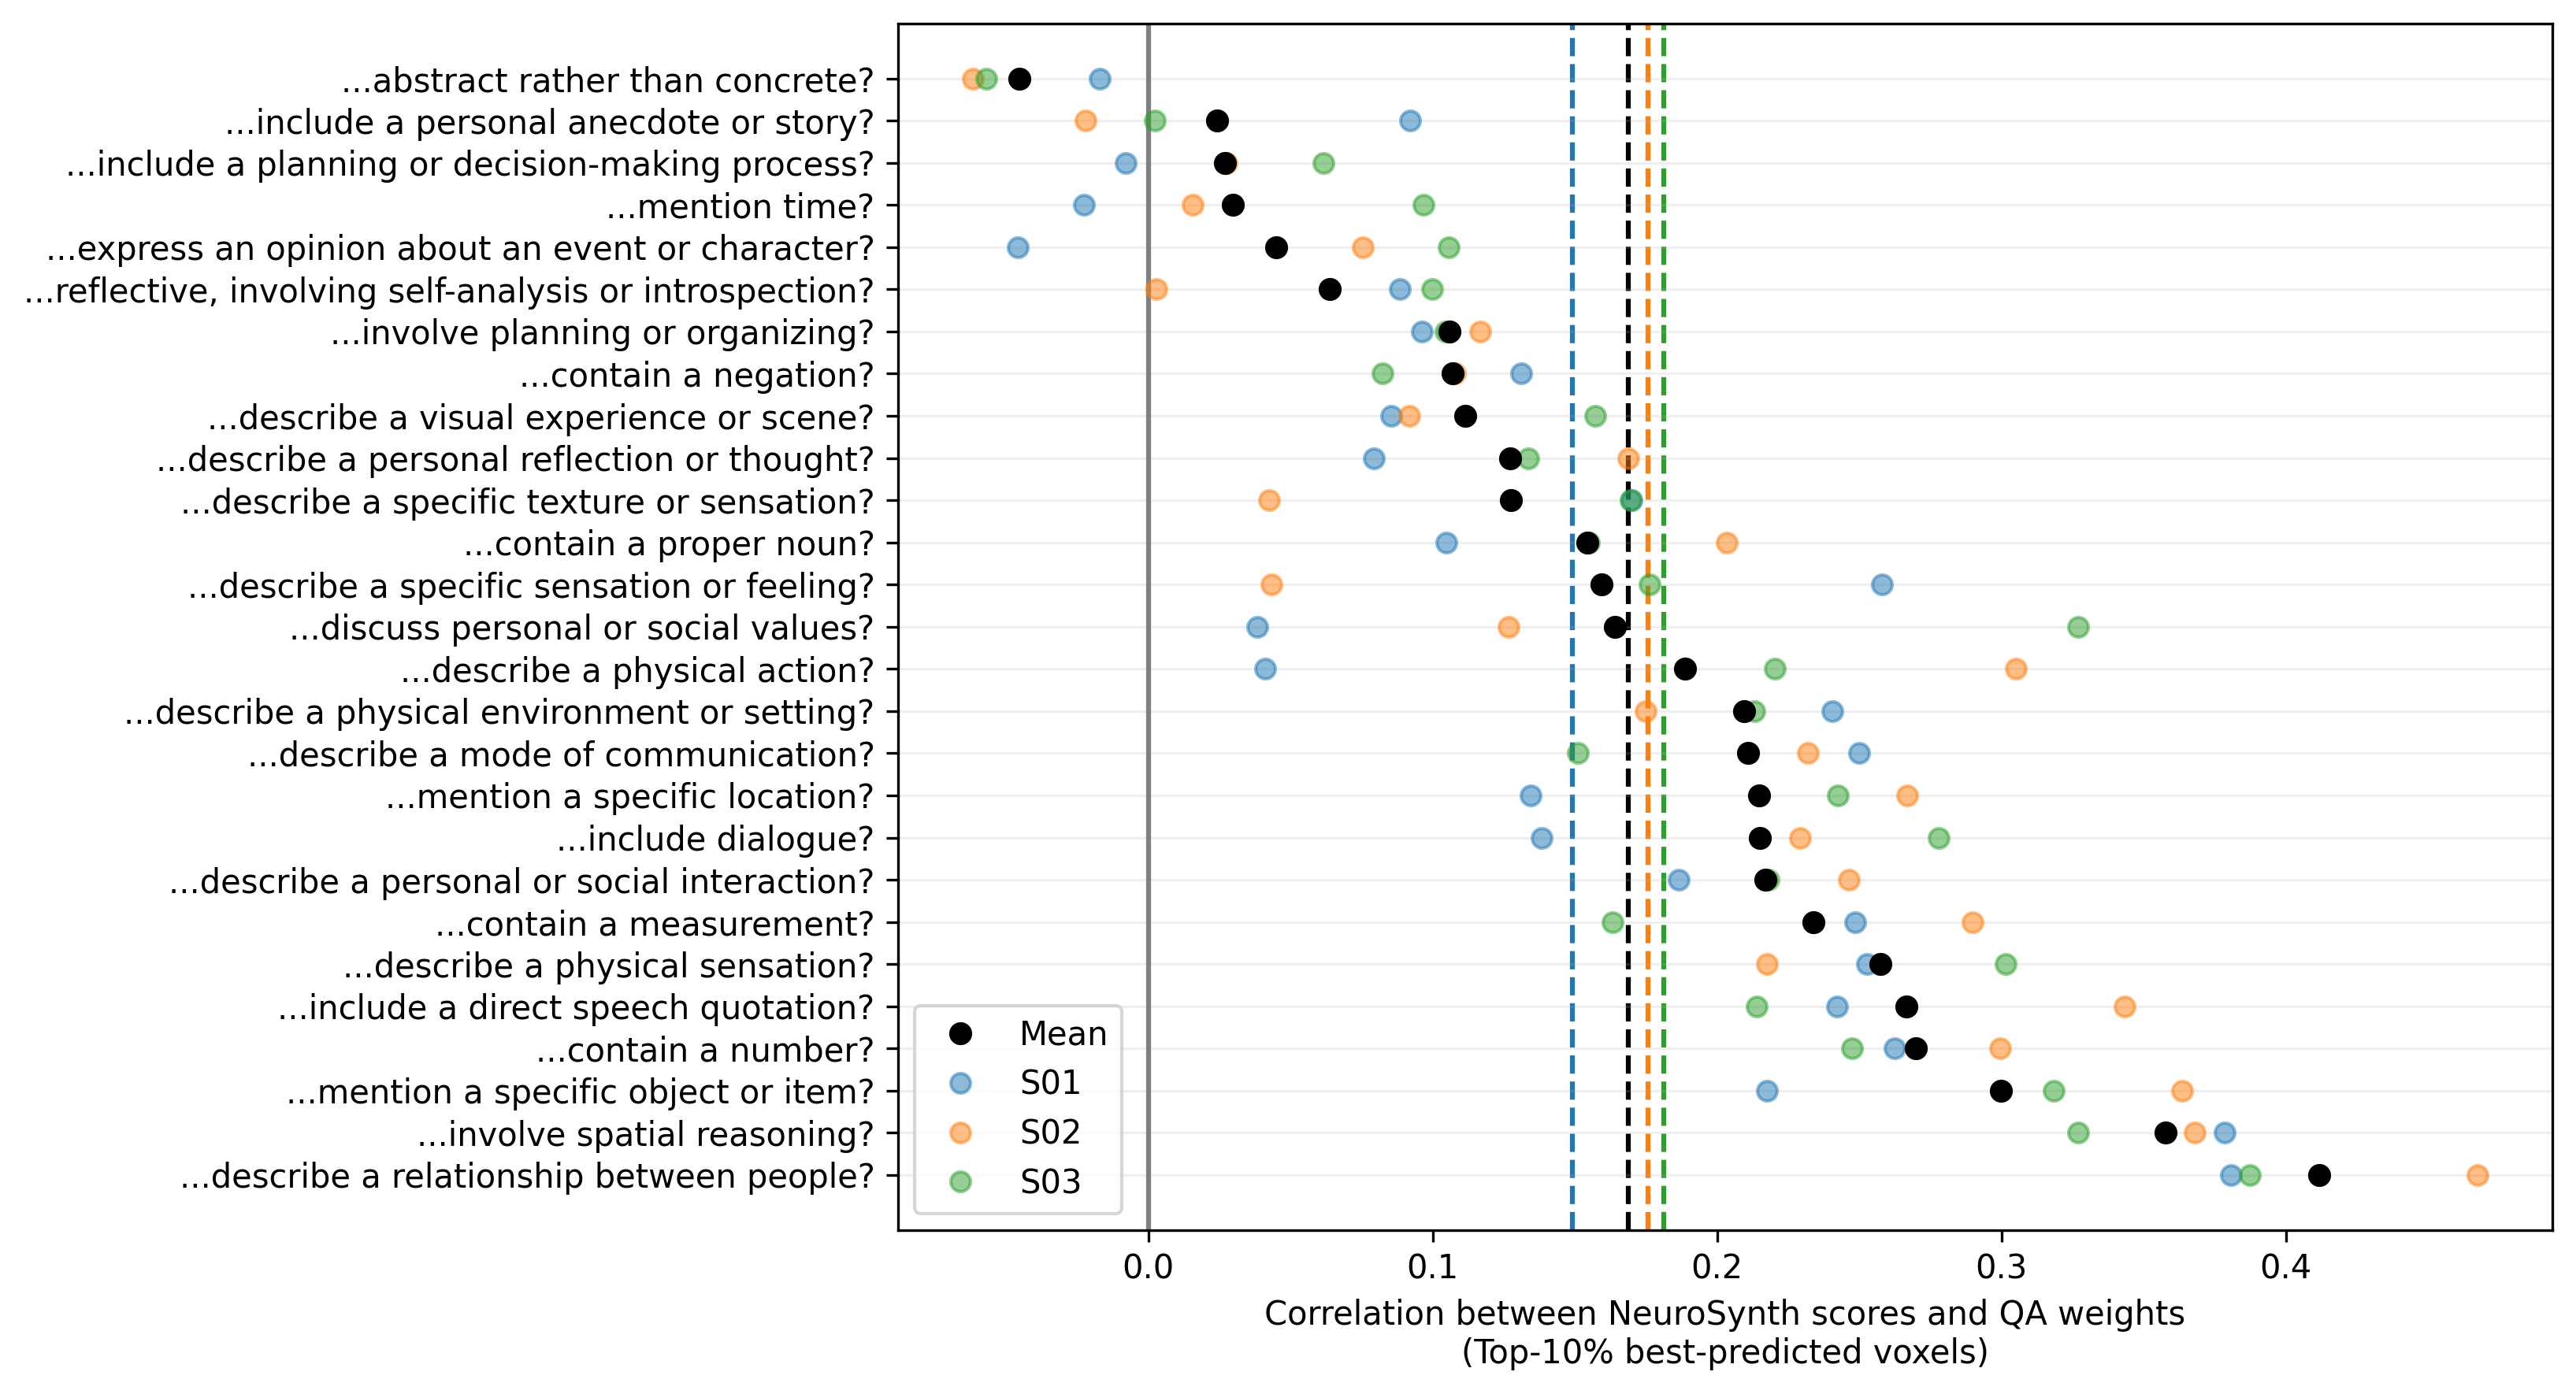

In [4]:
plt.figure(figsize=(11, 6), dpi=300)
# plt.figure(figsize=(8, 3), dpi=300) # for senses plot
neurosynth_compare.plot_corrs_df(
    corrs_df, out_dir, plot_val=f'corrs_{frac_voxels_to_keep}',
    xlab=f'Correlation between NeuroSynth scores and QA weights\n(Top-{int(100*frac_voxels_to_keep)}% best-predicted voxels)')
print('saved to', out_dir)

In [ ]:
!ls /home/chansingh/mntv1/deep-fMRI/qa/neurosynth_data/all_in_S01-BOLD

### statistical tests

In [ ]:
qs_35 = sorted([x[0] for x in corrs_df.questions.unique()])

for frac_voxels_to_keep in tqdm(frac_voxels_to_keep_list):
    # eng1000_dir = join(PROCESSED_DIR, subject.replace(
    # 'UT', ''), 'eng1000_weights.pkl')
    # flatmaps_null = joblib.load(eng1000_dir)
    baseline_distrs = []
    for subject in ['UTS01', 'UTS02', 'UTS03']:
        flatmaps_qa_list = [
            flatmaps_qa_dicts_by_subject[subject][k] for k in qs_35]
        flatmaps_null = np.array(joblib.load(
            join(config.PROCESSED_DIR, subject.replace('UT', ''), 'resp_chunks_1trs.pkl')))

        # print('shape', flatmaps_eng1000.shape)
        corrs_test = joblib.load(join(config.PROCESSED_DIR, subject.replace(
            'UT', ''), 'corrs_test_35.pkl')).values[0]
        _, baseline_distr = viz.compute_pvals(
            flatmaps_qa_list, frac_voxels_to_keep,
            corrs_df[f'corrs_{frac_voxels_to_keep}'].values,
            flatmaps_null=flatmaps_null, mask_corrs=corrs_test)

        baseline_distrs.append(baseline_distr)

        # get what fraction of 'corrs_perm_eng1000' column is greater than 'corrs'
    #     corrs_df[f'pval_{frac_voxels_to_keep}'] = pvals
    #     corrs_df[f'baseline_distr_{frac_voxels_to_keep}'] = basline_distr
    # for frac_voxels_to_keep in tqdm(frac_voxels_to_keep_list):
    #     corrs_df[f'pval_{frac_voxels_to_keep}_err_corrected'] = multipletests(
    #         pvals, method='fdr_bh', alpha=0.5)[1]

In [ ]:
vals_baseline = np.array(baseline_distrs).mean(axis=0)
vals_alt = corrs_df.groupby('questions')[
    f'corrs_{frac_voxels_to_keep}'].mean().sort_index().values

n = len(vals_alt)
print(np.mean(vals_alt))

# permutation test on mean
n_samples = 1000
means_baseline = [
    np.mean(np.random.choice(vals_baseline.flatten(), size=n, replace=False))
    for i in range(n_samples)
]
print('mean test p', np.mean(np.array(means_baseline) >= np.mean(vals_alt)))

# permutation test on individuals
pvals = []
for i in range(len(vals_baseline)):
    pvals.append(np.mean(vals_baseline[i] >= vals_alt[i]))
pvals = multipletests(
    pvals, method='fdr_bh', alpha=0.05)[1]
print('individual pvals (err corrected)', pvals)

### Evaluate possible matches

In [ ]:
corrs_tab = corrs_df.pivot_table(
    index='questions', columns='subject', values='corrs_0.1'
)
# add mean col
corrs_tab['mean'] = corrs_tab.mean(axis=1)
corrs_tab = corrs_tab.sort_values('mean', ascending=False).reset_index()

In [ ]:
with pd.option_context('display.float_format', '{:.3f}'.format,
                       'display.max_rows', None,
                       'display.max_columns', None):
    display(corrs_tab.sort_values(
        by=['questions', 'mean'], ascending=[True, False]).set_index('questions')[['mean']])

In [ ]:
tab_matches = defaultdict(list)
for x in term_dict_rev:
    (k, v) = x
    tab_matches['q'].append(k)
    tab_matches['term'].append(v)

for k in QS_35_STABLE:
    if k not in tab_matches['q']:
        tab_matches['q'].append(k)
        tab_matches['term'].append('NO MATCH')

tab_matches = pd.DataFrame(tab_matches)
tab_matches['q'] = [analyze_helper.abbrev_question(
    q) for q in tab_matches['q']]
tab_matches.to_csv('tab_matches.csv', index=False)

### View flatmaps in 1 plot

In [ ]:
corrs_df = pd.read_pickle(join('neurosynth', setting + '_corrs_df.pkl'))

In [ ]:
setting = 'shapley_neurosynth'
for subject in ['UTS01', 'UTS02', 'UTS03']:
    img_dir1 = join('neurosynth',
                    subject, 'neurosynth')
    img_dir2 = join('neurosynth',
                    subject, setting)

    # read images and combine them with their filenames on a single plot
    # fnames = os.listdir(img_dir1)
    # fnames = [f for f in fnames if f.endswith('.png')]
    # only keep the ones that are in both directories
    # fnames = [f for f in fnames if f in os.listdir(img_dir2)]

    corrs = corrs_df[corrs_df['subject'] == subject]
    # corrs = corrs.sort_values(f'corrs_{frac_voxels_to_keep}', ascending=False)
    fnames = [v + '.png' for v in corrs['questions'].values]

    n = len(fnames)
    C = 4
    R = int(np.ceil(n / C))

    fig, axs = plt.subplots(R, C, figsize=(C * 3.2, R * 1))
    axs = axs.flatten()
    for i in range(len(axs)):
        axs[i].axis('off')
    for i, fname in enumerate(fnames):
        img1 = plt.imread(join(img_dir1, fname))
        img2 = plt.imread(join(img_dir2, fname))
        axs[i].imshow(np.concatenate([img1, img2], axis=1))
        axs[i].set_title(
            f'{term_dict_rev[fname[:-4]]} ({corrs["corrs"].values[i]:0.3f})', fontsize=8)

    # add text in bottom right of figure
    fig.text(0.99, 0.01, f'{subject}\nNeurosynth on left, QA on right',
             ha='right', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(join(repo_dir, 'qa_results', 'neurosynth',
                subject, f'flatmaps_{setting}_{subject}.png'), dpi=300)
    plt.close()